# ValidateTempSalinity

Ben Roberts, 2022-2023

Perform a validtion of FVCOM water temperature and salinity output against observations compiled in a [database](https://github.com/bedaro/puget_sound_obsdata). This is loosely based on a Python notebook I wrote in summer 2020 for validation of King County's Puget Sound Aquatic Biogeochemical Cycling (PSABC) model, and most of the plots are designed to mimic the ones Ecology uses in their Bounding Scenarios report.

## Parameters

 * `model_output_pattern`: A glob pattern of all the NetCDF files from the hydrodynamic model run.
 * `run_name`: The name of this particular run, used to name the output files.
 * `start_date`: A plain text start date for when the model run began, which will be read with pd.Timestamp.
 * `end_date`: A plain text end date for when to stop validating the model output. This can just be set to None to use the end of the model output, but some ways to run the model let it continue running after boundary condition files have ended, and after that point this will corrupt the fit statistics.
 * `exclude_station_ids`: A sequence of station IDs to exclude from the validation, even though they fall within the model domain and had observations during the run period.
 * `stats_max_per_station`: To deal with automated buoys that have observations at a much higher frequency than human-collected data, any station with a total number of observations that exceeds this threshold will be subsampled randomly.
 * `sectionsfile` and `limiting_sections`: Optional; specify a transects config file and a list of transects that will be used to construct a ControlVolume that constrains the area of the validation, rather than use the entire model output grid
 * `fancy_station_map`: Makes a labeled map of all the observation stations used in the validation. Calculating label locations is quite slow due to one particularly inefficient python module. To speed up the notebook and skip the labeling, set this to False.

In [1]:
#model_output_pattern = '/home/benr/wqmodels/ssm/freshwater_iav_1/1_control/hyd/OUTPUT/netcdf/ssm_*.nc'
#run_name = 'freshwater_iav_control'

model_output_pattern = '/home/benr/wqmodels/ssm/ecology_bounding_outputs/2014_SSM4_WQ_Exist1_nodes.nc'
run_name = 'ecol_2014_SSM4_Exist1'
start_date = '2014-01-01'
#start_date = '2012-01-01'
end_date = '2014-12-31'
#end_date = None

# Don't validate with data from the Pacific coast (Willapa Bay, Grays Harbor)
#exclude_station_ids = ('WPA001','WPA003','WPA004','WPA006','WPA007',
#                       'WPA008','WPA102','WPA113','GYS004','GYS008',
#                       'GYS009','GYS015','GYS016')
exclude_station_ids = ()
stats_max_per_station = 240
# Parameters for validating only part of the model grid
sectionsfile = '../SSM_Grid/sections.ini'
#limiting_sections = ['HoodCanalEntrance']
limiting_sections = []

fancy_station_map = True

import glob
import os
import os.path as path
from multiprocessing import Pool
from time import perf_counter
from configparser import ConfigParser
import numpy as np
import pandas as pd
from netCDF4 import Dataset, MFDataset
import matplotlib.pyplot as plt
import contextily as cx
import db
from fvcom.grid import FvcomGrid
from fvcom.transect import Transect
from fvcom.control_volume import ControlVolume
import validation_util as vu

In [2]:
if len(glob.glob(model_output_pattern)) == 1:
    model_output = Dataset(model_output_pattern)
else:
    model_output = MFDataset(model_output_pattern)
model_output

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): IJK(160120), Time(8760)
    variables(dimensions): float32 Var_1(Time, IJK), float32 Var_2(Time, IJK), float32 Var_3(Time, IJK), float32 Var_4(Time, IJK), float32 Var_5(Time, IJK), float32 Var_6(Time, IJK), float32 Var_7(Time, IJK), float32 Var_8(Time, IJK), float32 Var_9(Time, IJK), float32 Var_10(Time, IJK), float32 Var_11(Time, IJK), float32 Var_12(Time, IJK), float32 Var_13(Time, IJK), float32 Var_14(Time, IJK), float32 Var_15(Time, IJK), float32 Var_16(Time, IJK), float32 Var_17(Time, IJK), float32 Var_18(Time, IJK), float32 Var_19(Time, IJK), float32 Var_20(Time, IJK), float32 Var_21(Time, IJK), float32 Var_22(Time, IJK), float32 Var_23(Time, IJK), float32 Var_24(Time, IJK), float32 Var_25(Time, IJK), float32 Var_26(Time, IJK), float32 Var_27(Time, IJK), float32 Var_28(Time, IJK), float32 Var_29(Time, IJK), float32 Var_30(Time, IJK), float32 Var_31(Time, IJK), float32 Var_

In [3]:
out_file = lambda name: path.join("notebook_outs", run_name, name)
os.makedirs(os.path.dirname(out_file('foo')), exist_ok=True)

In [4]:
if 'Var_1' in model_output.variables:
    grid = FvcomGrid.from_mesh('../SSM_Grid/ssm_grid.2dm')
    v = vu.EcolModelValidator(start_date, model_output, grid, end_date=end_date)
else:
    v = vu.ModelValidator(start_date, model_output, end_date=end_date)

display(f'Validation range from {v.start_date} to {v.end_date}')

'Validation range from 2014-01-01 08:00:00+00:00 to 2014-12-31 08:00:00+00:00'

In [5]:
sections = ConfigParser()
sections.read(sectionsfile)
transects = []
for s in limiting_sections:
    waypoints = np.array(sections[s]['waypoints'].split(' ')).astype(int)
    assert len(waypoints) >= 2, f'Not enough waypoints defined for section {s}'
    if 'upesty' in sections[s] and sections[s]['upesty'] == 'l':
        waypoints = waypoints[::-1]
    transects.append(Transect.shortest(v.grid, waypoints))
if len(transects) > 0:
    cv = ControlVolume.from_transects(transects)
else:
    # For the entire model grid
    #cv = ControlVolume(grid=v.grid, nodes=set(np.arange(v.grid.m)+1), calc=True)
    cv = None

In [6]:
(temp_obs, salt_obs), station_nodes = v.get_obsdata(('temp','salt'), cv=cv, exclude_stations=exclude_station_ids)
print(f'{len(temp_obs)} total temperature measurements in {len(temp_obs.dropna(subset="cast_id").drop_duplicates(subset="cast_id"))} total casts')
display(temp_obs.head())
print(f'{len(salt_obs)} total salinity measurements in {len(salt_obs.dropna(subset="cast_id").drop_duplicates(subset="cast_id"))} total casts')
display(salt_obs.head())

733273 total temperature measurements in 9879 total casts


,datetime,depth,value,location_id,cast_id,parameter_id,description,geom,node
id,,,,,,,,,
94070015,2014-01-01 08:00:00+00:00,1.204,8.92,PointWilliams,None,temp,Point Williams,POINT (544695.723 5265030.897),10977
94070016,2014-01-01 08:15:00+00:00,1.214,8.92,PointWilliams,None,temp,Point Williams,POINT (544695.723 5265030.897),10977
94070017,2014-01-01 08:30:00+00:00,1.218,8.92,PointWilliams,None,temp,Point Williams,POINT (544695.723 5265030.897),10977
94070018,2014-01-01 08:45:00+00:00,1.219,8.92,PointWilliams,None,temp,Point Williams,POINT (544695.723 5265030.897),10977
94070019,2014-01-01 09:00:00+00:00,1.219,8.91,PointWilliams,None,temp,Point Williams,POINT (544695.723 5265030.897),10977


716100 total salinity measurements in 9879 total casts


,datetime,depth,value,location_id,cast_id,parameter_id,description,geom,node
id,,,,,,,,,
99861603,2014-01-01 20:23:59.499996+00:00,2.772962,30.076366,HC_DB,4a749a27-5f0b-467d-9cd9-3465576500ba,salt,Dabob Bay ORCA Buoy,POINT (514758.545 5294468.133),11313
99861605,2014-01-01 20:24:15.999996+00:00,3.985385,30.085354,HC_DB,4a749a27-5f0b-467d-9cd9-3465576500ba,salt,Dabob Bay ORCA Buoy,POINT (514758.545 5294468.133),11313
99861609,2014-01-01 20:24:22.249996+00:00,4.962500,30.086858,HC_DB,4a749a27-5f0b-467d-9cd9-3465576500ba,salt,Dabob Bay ORCA Buoy,POINT (514758.545 5294468.133),11313
99861612,2014-01-01 20:24:28.499996+00:00,5.928692,30.086315,HC_DB,4a749a27-5f0b-467d-9cd9-3465576500ba,salt,Dabob Bay ORCA Buoy,POINT (514758.545 5294468.133),11313
99861615,2014-01-01 20:24:34.999996+00:00,6.960231,30.085700,HC_DB,4a749a27-5f0b-467d-9cd9-3465576500ba,salt,Dabob Bay ORCA Buoy,POINT (514758.545 5294468.133),11313


In [7]:
# If there are too many stations this code will consume too much memory. Disable for now in that case.
if len(station_nodes) < 50:
    full_grid = v.grid.tces_gdf()
    fig, ax = plt.subplots(figsize=(12,12))
    p = station_nodes.plot(ax=ax, color='tab:orange', zorder=2)
    # Save the axes boundaries so we can restore them after plotting the full model
    # boundary
    xmin, xmax, ymin, ymax = p.axis()
    if fancy_station_map:
        from adjustText import adjust_text
        import matplotlib.patheffects as pe
        texts = station_nodes.apply(
            lambda x: ax.annotate(x.name, xy=x['geom'].coords[0], ha='center', va='center',
                                  path_effects=[pe.withStroke(linewidth=3, foreground="white", alpha=0.6)]
                                 ), axis=1).to_list()
        adjust_text(texts, arrowprops=dict(arrowstyle='-'))
    full_grid.plot(ax=ax, alpha=0.8, zorder=1)
    ax.set(title=f'Observation locations: {v.start_date.date()} to {v.end_date.date()}',
           ybound=(ymin, ymax), xbound=(xmin, xmax), xticklabels=(), yticklabels=())
    cx.add_basemap(ax, crs=full_grid.crs, source=cx.providers.CartoDB.Positron)
    if fancy_station_map:
        fig.savefig(out_file("stations_map.png"))

In [8]:
start = perf_counter()
# Group by cast
dfs = [v.process_cast(c, group) for c,group in temp_obs.groupby('cast_id')]
# This won't work right now because MFDataset can't be parallelized (not
# picklable). Migrating over to xarray is the only way forward I know of
#with Pool() as pool:
#    dfs = pool.starmap(v.process_cast, temp_obs.groupby('cast_id'))
# Handle the observations that aren't part of a (large enough) cast
dfs.append(v.process_nocast(temp_obs.loc[temp_obs['cast_id'].isna()]))

temp_validation_df = pd.concat(dfs, ignore_index=True)
del dfs
print("processing took {0:.3f} secs".format(perf_counter()-start))
temp_validation_df.to_csv(out_file("temp_validation.csv"), index=False)
temp_validation_df

processing took 21.307 secs


,location,node,cast_id,datetime,t,depth,sigma,observed,model
0,CI,14490,0004ea09-fa56-4420-b0bc-d2c6f0718eea,2014-08-16 04:12:35.500004+00:00,5444,3.305643,2,14.632815,14.6235
1,CI,14490,0004ea09-fa56-4420-b0bc-d2c6f0718eea,2014-08-16 04:12:35.500004+00:00,5444,6.928796,3,13.592516,13.2046
2,CI,14490,0004ea09-fa56-4420-b0bc-d2c6f0718eea,2014-08-16 04:12:35.500004+00:00,5444,11.394173,4,13.406941,12.3592
3,CI,14490,0004ea09-fa56-4420-b0bc-d2c6f0718eea,2014-08-16 04:12:35.500004+00:00,5444,16.561200,5,13.050747,12.1016
4,CI,14490,0004ea09-fa56-4420-b0bc-d2c6f0718eea,2014-08-16 04:12:35.500004+00:00,5444,22.343649,6,12.893244,12.0330
...,...,...,...,...,...,...,...,...,...
91653,LSEP01,10186,NaN,2014-10-06 19:28:57+00:00,6683,1.000000,1,13.258400,12.0057
91654,MSJN02,11783,NaN,2014-10-21 19:29:08+00:00,7043,1.000000,1,13.011500,11.6153
91655,LSNT01,10975,NaN,2014-11-04 19:58:55+00:00,7380,0.500000,1,12.329400,11.1865
91656,LSNT01,10975,NaN,2014-11-04 19:59:01+00:00,7380,1.000000,1,12.318600,11.1865


In [9]:
# Group by cast
dfs = [v.process_cast(c, group) for c,group in salt_obs.groupby('cast_id')]
# Handle the observations that aren't part of a (large enough) cast
dfs.append(v.process_nocast(salt_obs.loc[salt_obs['cast_id'].isna()]))

salt_validation_df = pd.concat(dfs, ignore_index=True)
del dfs
salt_validation_df.to_csv(out_file("salt_validation.csv"), index=False)
salt_validation_df

,location,node,cast_id,datetime,t,depth,sigma,observed,model
0,CI,14490,0004ea09-fa56-4420-b0bc-d2c6f0718eea,2014-08-16 04:12:35.500004+00:00,5444,3.305643,2,29.072049,28.726801
1,CI,14490,0004ea09-fa56-4420-b0bc-d2c6f0718eea,2014-08-16 04:12:35.500004+00:00,5444,6.928796,3,29.168654,28.829901
2,CI,14490,0004ea09-fa56-4420-b0bc-d2c6f0718eea,2014-08-16 04:12:35.500004+00:00,5444,11.394173,4,29.201983,28.965700
3,CI,14490,0004ea09-fa56-4420-b0bc-d2c6f0718eea,2014-08-16 04:12:35.500004+00:00,5444,16.561200,5,29.256126,29.039499
4,CI,14490,0004ea09-fa56-4420-b0bc-d2c6f0718eea,2014-08-16 04:12:35.500004+00:00,5444,22.343649,6,29.303399,29.082500
...,...,...,...,...,...,...,...,...,...
74480,LSEP01,10186,NaN,2014-10-06 19:28:57+00:00,6683,1.000000,1,30.247200,27.735701
74481,MSJN02,11783,NaN,2014-10-21 19:29:08+00:00,7043,1.000000,1,30.237100,29.079599
74482,LSNT01,10975,NaN,2014-11-04 19:58:55+00:00,7380,0.500000,1,30.214500,28.031700
74483,LSNT01,10975,NaN,2014-11-04 19:59:01+00:00,7380,1.000000,1,30.139200,28.031700


,Metric,R,RMSE,NSE,Bias,n
0,Temperature,0.821150,1.452907,0.639263,-0.446867,16711
1,Salinity,0.803876,1.421533,0.617709,-0.378083,16471


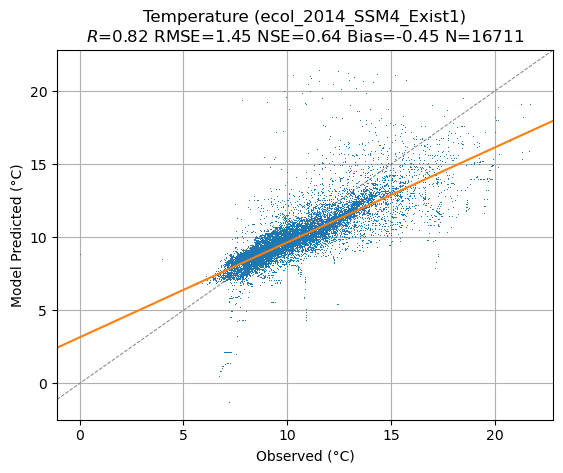

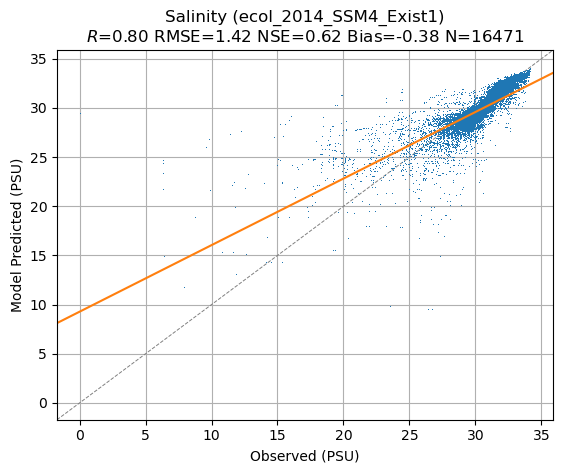

In [10]:
cum_stats = []
for pfx, label, data, unit in zip(('temp','salt'),
        ("Temperature","Salinity"),
        (temp_validation_df,salt_validation_df),
        ("\u00b0C","PSU")):
    if data.empty:
        continue
    # Downsample any stations with a high number of total observations
    # (ie automated buoys), otherwise a small number of stations will skew
    # the results heavily toward just showing how well the model represents
    # a handful of locations
    sampled = []
    for s,group in data.groupby('location'):
        if len(group) > stats_max_per_station:
            samp = group.sample(n=stats_max_per_station)
        else:
            samp = group
        sampled.append(samp)
    sampled_df = pd.concat(sampled)
    fit, rsq, rmse, nse, bias, n = vu.run_stats(sampled_df["observed"], sampled_df["model"])
    fig, ax = plt.subplots()
    vu.plot_fit(ax, sampled_df['observed'], sampled_df['model'], f'{label} ({run_name})', unit=unit)
    fig.savefig(out_file(f'{pfx}_validation.png'))
    cum_stats.append([label, rsq, rmse, nse, bias, n])

display(pd.DataFrame(cum_stats, columns=["Metric","R","RMSE","NSE", "Bias","n"]))

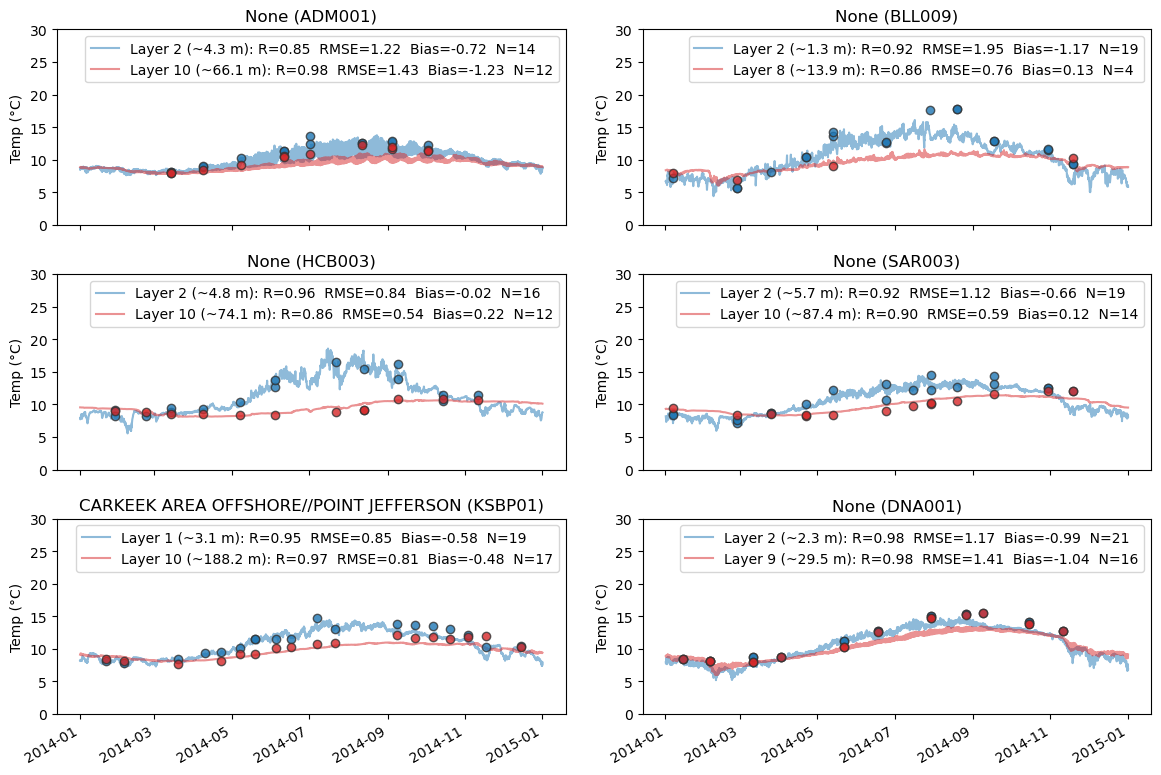

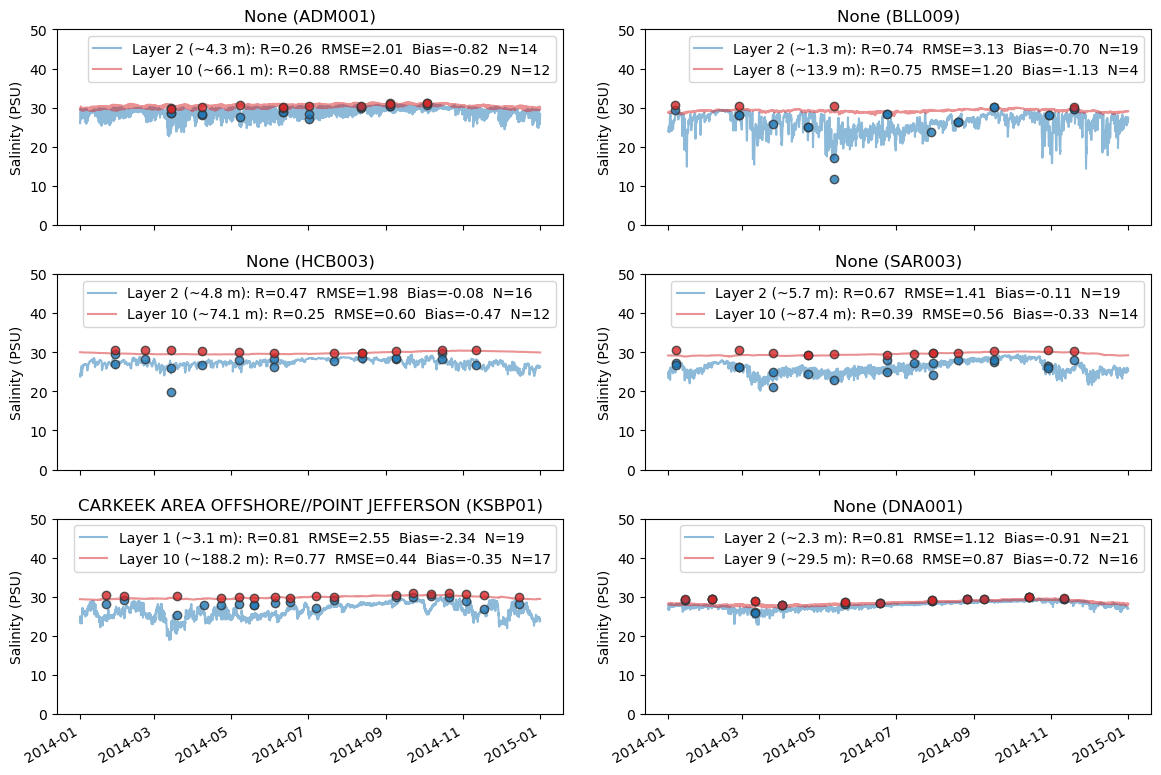

In [11]:
# Build time series plots of temperature and salinity that
# mimic figs 19 and 20 in the Bounding Scenarios report

plot_stations = ["ADM001","BLL009","HCB003","SAR003","KSBP01","DNA001"]
colors = ('tab:blue','tab:red')
datasets = {
    "temp": {
        "data": temp_validation_df,
        "obsdata": temp_obs,
        "ylabel": "Temp (\u00b0C)",
        "ybound": (0, 30),
        "xbound": (5, 27)
    },
    "salt": {
        "data": salt_validation_df,
        "obsdata": salt_obs,
        "ylabel": "Salinity (PSU)",
        "ybound": (0, 50),
        "xbound": (5, 35)
    }
}

for key,vals in datasets.items():
    data = vals['data']
    fig, axs = plt.subplots(3,2, figsize=(12,9))
    for ax,s in zip(np.array(axs).flatten(), plot_stations):
        zs = vu.tsplot_zs(v, data.loc[data["location"] == s])
        for z,color in zip(zs, colors):
            selector = (data["location"] == s) & (data["sigma"] == z)
            observed = data.loc[selector]
            if len(observed) == 0:
                # No observations at this station!
                node = station_nodes.loc[s, 'node']
                lbl = f'Layer {z}'
            else:
                havg = observed['depth'].mean()
                lbl = f'Layer {z} (~{havg:.1f} m)'
                node = observed.iloc[0]['node']
                ax.plot(observed["datetime"], observed["observed"], "o",
                        color=color, alpha=0.8, markeredgecolor='.2', zorder=2)

                if len(observed) > 2:
                    fit, r, rmse, ns, bias, n = vu.run_stats(observed["observed"],
                                                         observed["model"])
                    lbl += ": R=%.2f  RMSE=%.2f  Bias=%.2f  N=%d" % (r, rmse, bias, n)

            # Extract the full time series from the output file
            modeled_y = v.get_model_match(key, slice(None), z-1,node-1)
            modeled_x = v.get_times()
            ax.plot(modeled_x, modeled_y, color=color, alpha=0.5, label=lbl, zorder=1)
        ax.set(title=f'{station_nodes.loc[s, "description"]} ({s})',
               ylabel=vals['ylabel'], ybound=vals['ybound'])
        ax.legend()
    plt.tight_layout()
    fig.autofmt_xdate()
    fig.savefig(out_file(f'{key}_validation_station_ts.png'))

Mimic figures 22 and 23 from the Bounding Scenarios report

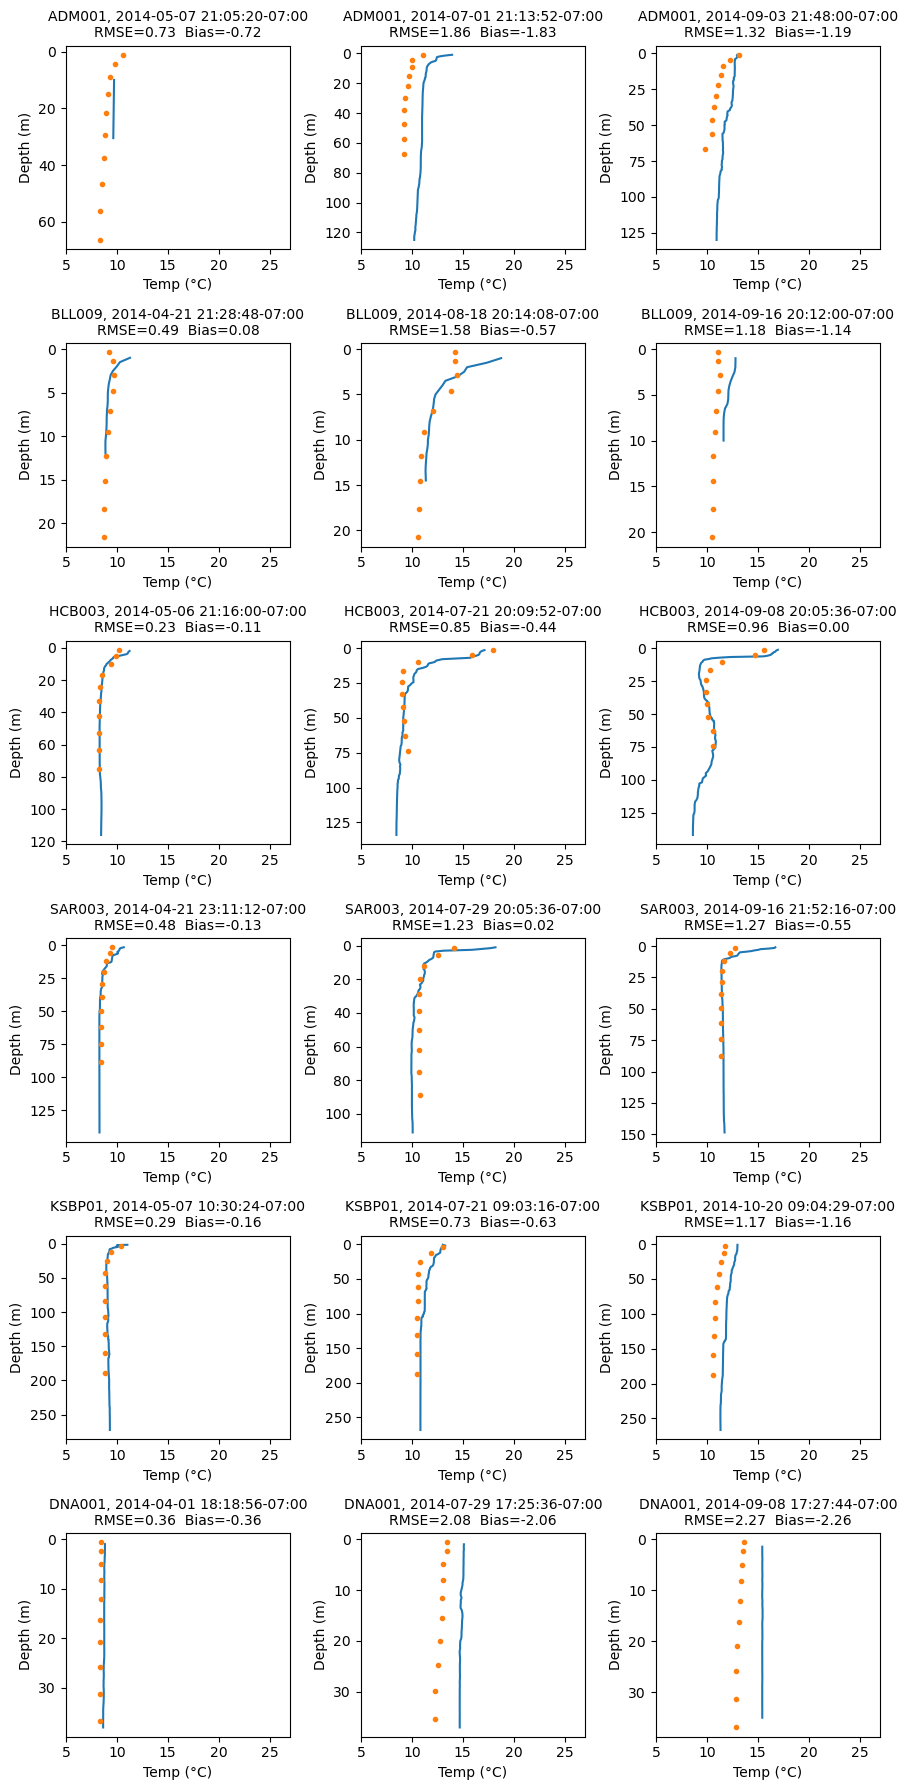

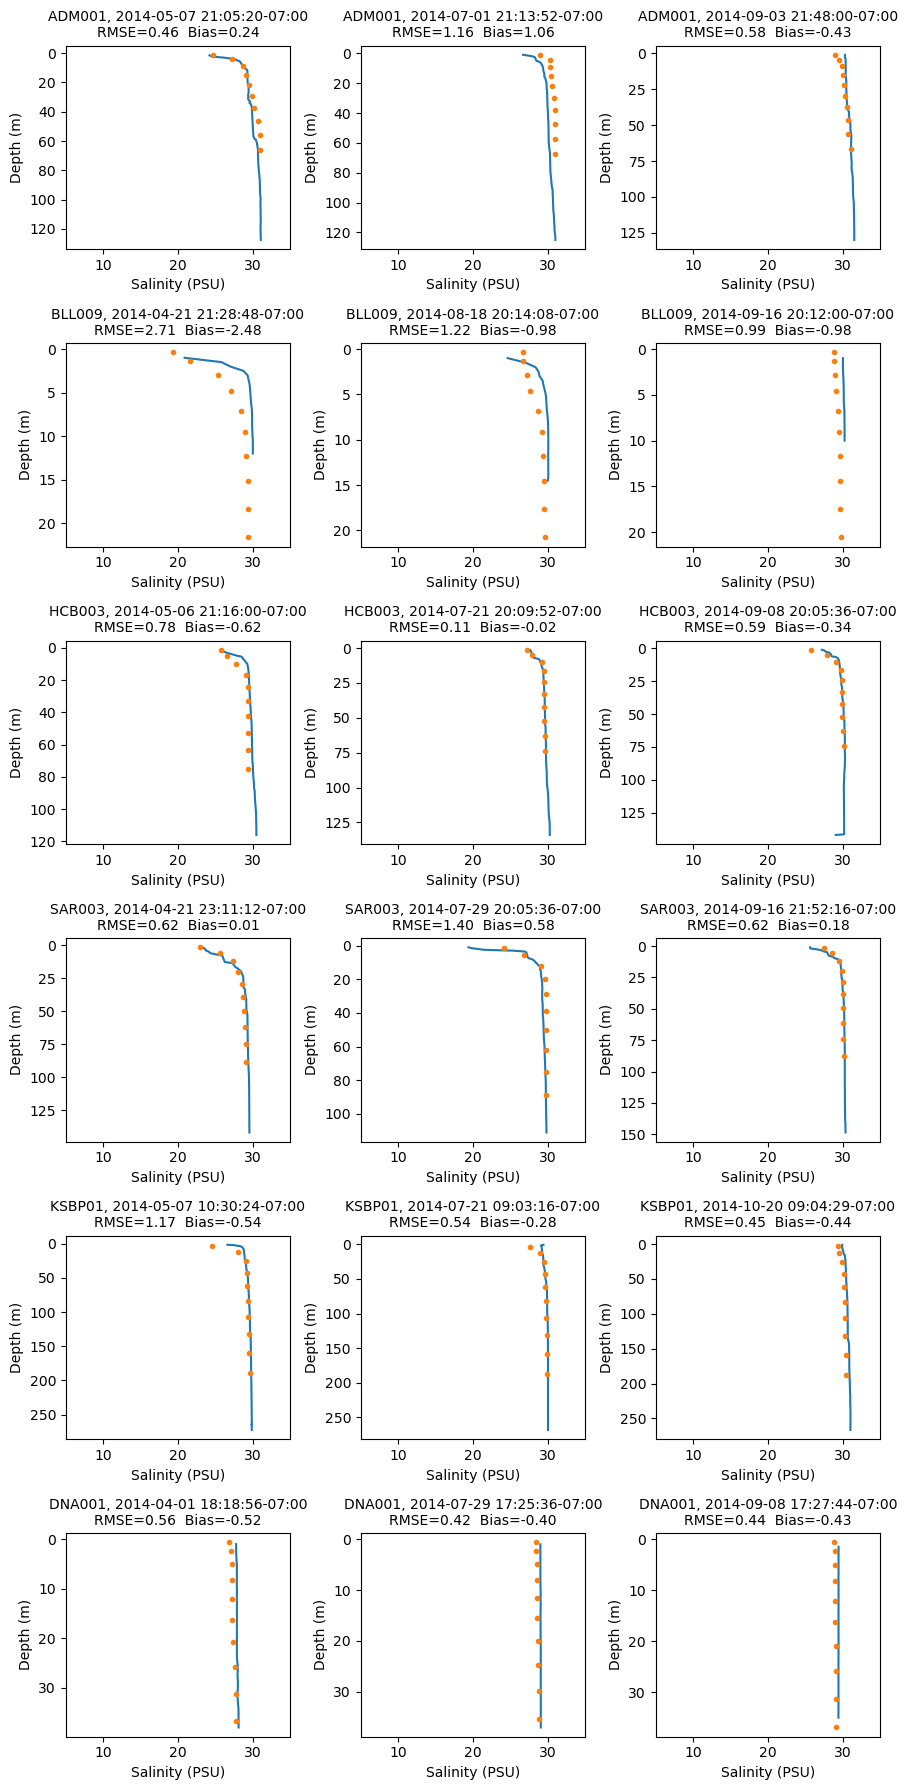

In [12]:
# Ranges of months to generate profile plots for
month_ranges = (
    (4, 5),
    (7, 8),
    (9, 10)
)
rand_seed = 4

for key,vals in datasets.items():
    fig, axs = plt.subplots(len(plot_stations), len(month_ranges),
                            figsize=(3*len(month_ranges), 3 * len(plot_stations)))
    d = vals['data']
    od = vals['obsdata']
    # Keep track of whether or not we found anything to plot among the ranges
    # given from this dataset
    plotted = False
    for i,mr in enumerate(month_ranges):
        for j,s in enumerate(plot_stations):
            ax = axs[j,i]
            # Pick a "random" cast from the time range, using a constant seed for reproducibility
            cast_candidates = od.loc[
                (od['datetime'].dt.month >= mr[0]) & (od['datetime'].dt.month <= mr[-1]) \
                & (od['location_id'] == s) & ~od['cast_id'].isna(), 'cast_id'
            ]
            if len(cast_candidates) == 0:
                continue
            obs_cast_id = cast_candidates.sample(1, random_state=rand_seed).iloc[0]

            obs = od.loc[od['cast_id'] == obs_cast_id].sort_values(by='depth')
            ax.plot(obs['value'], obs['depth'])
            cast_dt = obs['datetime'].iloc[0].tz_convert('US/Pacific')

            # Get model results that correspond to this cast_id. Use vals['data'] to fetch node and t,
            # retrieve all sigma layers, then recalculate matching depths using the same method as
            # process_cast
            node = obs['node'].iloc[0]
            cast_selector = d['cast_id'] == obs_cast_id
            t = d.loc[cast_selector, 't'].iloc[0]
            modeled_x = v.get_model_match(key, t, slice(None), node-1)
            modeled_y = ((v.grid.ncoord[2, node-1] + v._get_ssh(t, node-1))
                         * v.depthcoord.zz[:-1] * -1)
            ax.plot(modeled_x, modeled_y, '.')
            
            fit, r, rmse, ns, bias, n = vu.run_stats(d.loc[cast_selector, "observed"],
                                                 d.loc[cast_selector, "model"])

            ax.set_title(f'{s}, {cast_dt}\nRMSE={rmse:.2f}  Bias={bias:.2f}', fontsize=10)
            ax.set(ylabel='Depth (m)', xlabel=vals['ylabel'], xbound=vals['xbound'])
            ax.set_ylim(ax.get_ylim()[::-1]) #this reverses the yaxis (i.e. deep at the bottom)
            plotted = True

    if plotted:
        fig.tight_layout()
        fig.savefig(out_file(f'{key}_validation_station_pr.png'))
    else:
        plt.close(fig)

Temperature skill by layer

In [13]:
temp_skill_by_layer = []
for s,group in temp_validation_df.groupby('sigma'):
    fit, rsq, rmse, ns, bias, n = vu.run_stats(group["observed"], group["model"])
    temp_skill_by_layer.append((s,rsq,rmse,bias,n))
temp_skill_by_layer_df = pd.DataFrame(temp_skill_by_layer, columns=('sigma','R','RMSE','Bias','N')).set_index('sigma')
temp_skill_by_layer_df.to_csv(out_file('temp_skill_by_layer.csv'))
temp_skill_by_layer_df

,R,RMSE,Bias,N
sigma,,,,
1,0.907283,0.787770,0.173248,18016
2,0.869502,1.544549,-0.653489,7786
3,0.817926,1.404954,-0.439903,9619
4,0.819902,1.142119,-0.380893,9641
5,0.867061,0.977631,-0.358918,9595
6,0.897211,0.903787,-0.350989,9503
7,0.902754,0.871552,-0.314637,9296
8,0.901492,0.841535,-0.251522,7778
9,0.801847,0.880306,-0.118286,5269


Temperature skill over time

In [14]:
per_month = []
for name, group in temp_validation_df.groupby(temp_validation_df["datetime"].dt.date):
    fit, rsq, rmse, ns, bias, n = vu.run_stats(group['observed'], group['model'])
    per_month.append([name, rsq, rmse, bias, n])

per_month_stats = pd.DataFrame(per_month, columns=["Date","R","RMSE","Bias","n"])
per_month_stats.to_csv(out_file('temp_skill_per_month.csv'))
per_month_stats

,Date,R,RMSE,Bias,n
0,2014-01-01,0.705554,0.455204,-0.351969,73
1,2014-01-02,0.375605,0.377196,-0.150054,114
2,2014-01-03,0.286157,0.337706,0.115582,114
3,2014-01-04,0.016441,0.382953,0.131850,114
4,2014-01-05,0.399997,0.329707,-0.011870,114
...,...,...,...,...,...
359,2014-12-26,0.718591,0.776005,-0.692499,32
360,2014-12-27,0.918599,0.696127,-0.651266,32
361,2014-12-28,0.743524,0.841744,-0.751918,32
362,2014-12-29,0.202231,0.890813,-0.717322,24


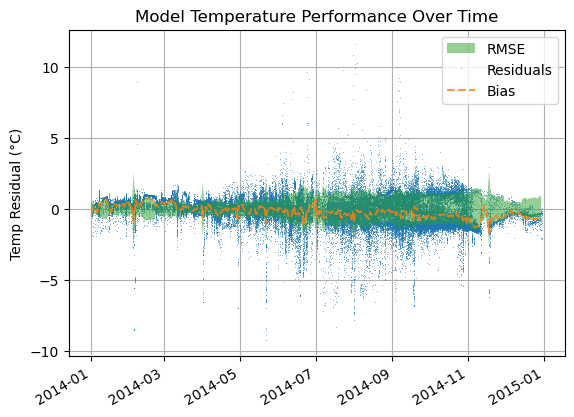

In [15]:
# Plot temperature residuals over time
temp_resids = temp_validation_df["model"] - temp_validation_df["observed"]
fig, ax = plt.subplots()
ax.fill_between(per_month_stats["Date"],
                per_month_stats["RMSE"],
                -per_month_stats["RMSE"],
                facecolor="tab:green", alpha=0.5, label="RMSE", zorder=4)
ax.plot(temp_validation_df["datetime"].to_numpy(), temp_resids, ",", label="Residuals", alpha=0.5)
ax.plot(per_month_stats["Date"].to_numpy(), per_month_stats["Bias"], "--", label="Bias", alpha=0.8, zorder=5)
ax.set(title="Model Temperature Performance Over Time", ylabel="Temp Residual (\u00b0C)")
ax.grid()
ax.legend()
fig.autofmt_xdate()
fig.savefig(out_file("temp_skill_vs_t.png"))